In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### Hyperparameters setup

In [2]:
batch_size=100
lr=1e-3
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Downloading MNIST data

In [3]:
train_ds = datasets.MNIST(root = './data', train = True, download = True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))

test_ds = datasets.MNIST(root = './data', train = False, download = True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))

Train/Test dataset sizes: 60000/10000


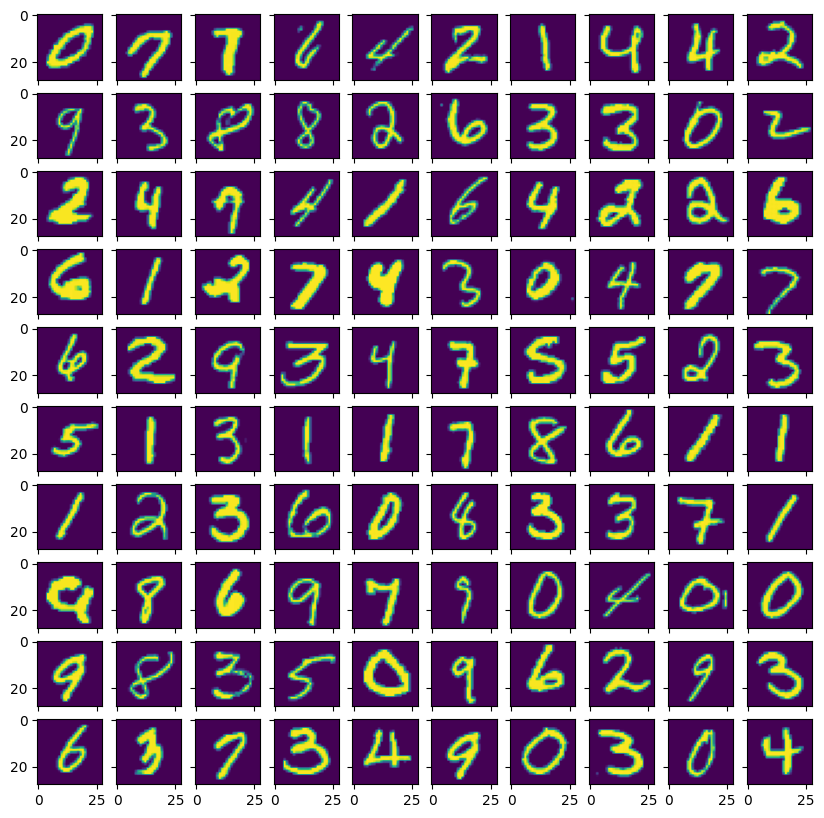

In [4]:
print(f"Train/Test dataset sizes: {train_ds.__len__()}/{test_ds.__len__()}")

n=10
fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10, 10))

for i in range(n):
    for j in range(n):
        k = random.randint(0, train_ds.__len__())
        x, y = train_ds.__getitem__(k)
        axes[i, j].imshow(x[0])

### MNIST Dataloaders

In [4]:
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

### Building model

In [5]:
class MISTClassifierModel(nn.Module):
    def __init__(self, inp_channels, n_classes) -> None:
        super(MISTClassifierModel, self).__init__()
        self.conv1 = nn.Conv2d(inp_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50) # flattened size=320
        self.fc2 = nn.Linear(50, n_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.dropout2d(x, p=0.3)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout2d(x, p=0.3)

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3)
        x = self.fc2(x)
        return x

### Initializeing model, loss function and an optimizer

In [6]:
model = MISTClassifierModel(inp_channels=1, n_classes=10)
model.to(device)

# test with a random input
inp = torch.rand(2, 1, 28, 28).to(device) # batch_size, channels, height, width
model(inp)

tensor([[ 0.0713, -0.1562,  0.0769,  0.0291, -0.0518,  0.0530,  0.0481,  0.1481,
          0.0457, -0.0098],
        [ 0.1651, -0.1197,  0.0439, -0.0291,  0.0856,  0.0814, -0.0140,  0.1828,
          0.1317,  0.1034]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

### Random-model's prediction

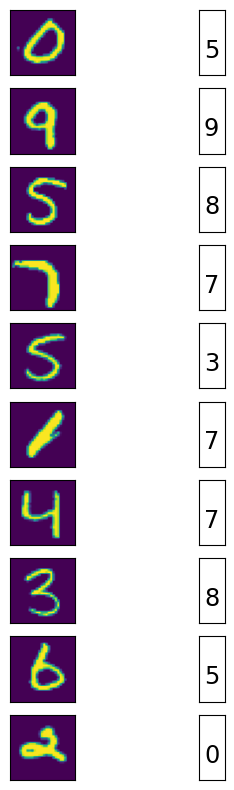

In [8]:
fig, axes = plt.subplots(nrows=10, ncols=2, sharex=True, sharey=True, figsize=(4, 10), width_ratios=[10,1])

for i in range(10):
    k = random.randint(0, test_ds.__len__())
    x, y = test_ds.__getitem__(k)
    x, y = x.to(device), y
    y_pred = model(x.unsqueeze(0))
    y_pred = torch.argmax(y_pred)
    x, y_pred = x.cpu().numpy(), y_pred.cpu().numpy()
    axes[i, 0].imshow(x[0])
    axes[i, 1].text(5, 20, str(y_pred), size="xx-large")
    # break

plt.xticks([])
plt.yticks([])
plt.show()

### Training the model

In [9]:
def train(epoch):
    model.train()

    for i , (X, Y) in enumerate(train_dl):
        X, Y = X.to(device), Y.to(device)
      
        optimizer.zero_grad()
        Y_preds = model(X)
        loss = loss_func(Y_preds, Y)
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
          print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_dl)//batch_size, loss.item()))


def test():
    model.eval()
    total_loss = 0.0
    correct = 0
    for i, (X, Y) in enumerate(test_dl):
        X, Y = X.to(device), Y.to(device)
        Y_preds = model(X)

        loss = loss_func(Y_preds, Y)
        total_loss += loss.item()

        Y_preds = torch.argmax(Y_preds, dim=1) 
        correct += (Y_preds==Y).sum()
        # if i==5: break

    
    n_datapoints_checked = (i+1)*len(test_dl)
    total_loss /= n_datapoints_checked
    correctness = (100. * correct) / n_datapoints_checked
    print(f"\nAverage loss: {total_loss:.4f}, Accuracy: {correct}/{n_datapoints_checked} ({correctness:.0f}%)\n")

In [10]:
for epoch in range(num_epochs):
    train(epoch)
    test()

Epoch [1/10], Step [1/6], Loss: 2.3082
Epoch [1/10], Step [101/6], Loss: 0.5883
Epoch [1/10], Step [201/6], Loss: 0.3561
Epoch [1/10], Step [301/6], Loss: 0.3741
Epoch [1/10], Step [401/6], Loss: 0.2602
Epoch [1/10], Step [501/6], Loss: 0.3330

Average loss: 0.0021, Accuracy: 9426/10000 (94%)

Epoch [2/10], Step [1/6], Loss: 0.1479
Epoch [2/10], Step [101/6], Loss: 0.3761
Epoch [2/10], Step [201/6], Loss: 0.3728
Epoch [2/10], Step [301/6], Loss: 0.1121
Epoch [2/10], Step [401/6], Loss: 0.1328
Epoch [2/10], Step [501/6], Loss: 0.1581

Average loss: 0.0016, Accuracy: 9531/10000 (95%)

Epoch [3/10], Step [1/6], Loss: 0.1360
Epoch [3/10], Step [101/6], Loss: 0.2879
Epoch [3/10], Step [201/6], Loss: 0.1097
Epoch [3/10], Step [301/6], Loss: 0.1795
Epoch [3/10], Step [401/6], Loss: 0.1633
Epoch [3/10], Step [501/6], Loss: 0.2038

Average loss: 0.0013, Accuracy: 9633/10000 (96%)

Epoch [4/10], Step [1/6], Loss: 0.2405
Epoch [4/10], Step [101/6], Loss: 0.1559
Epoch [4/10], Step [201/6], Loss: 0

### Tranined model's prediction

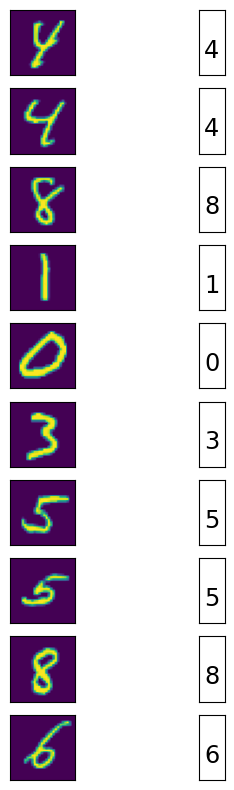

In [12]:
fig, axes = plt.subplots(nrows=10, ncols=2, sharex=True, sharey=True, figsize=(4, 10), width_ratios=[10,1])

for i in range(10):
    k = random.randint(0, test_ds.__len__())
    x, y = test_ds.__getitem__(k)
    x, y = x.to(device), y
    y_pred = model(x.unsqueeze(0))
    y_pred = torch.argmax(y_pred)
    x, y_pred = x.cpu().numpy(), y_pred.cpu().numpy()
    axes[i, 0].imshow(x[0])
    axes[i, 1].text(5, 20, str(y_pred), size="xx-large")
    # break

plt.xticks([])
plt.yticks([])
plt.show()